# I. Installation Requirements & Data Import

In [12]:
# Install required dependencies
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn import set_config
from sklearn.metrics import r2_score
import h5py
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import pandas as pd
import numpy as np
import warnings
from transformers import (
    ResNetModel,
    TrainingArguments,
    Trainer,
    ResNetConfig,
    ResNetForImageClassification,
)
import torch
import torchvision.transforms as transforms
import evaluate
from datasets import Dataset
import altair as alt

warnings.filterwarnings("ignore")
set_config(display="diagram")
# Optional for clear plotting on Macs
%config InlineBackend.figure_format = 'retina'

In [3]:
# Uncomment code below to download data
# !wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_train.h5
# !wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_val.h5
# !wget -q https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_test.h5

In [30]:
# Read data files
trainset = h5py.File("09072022_1154_train.h5", "r")
validateset = h5py.File("09072022_1154_val.h5", "r")
testset = h5py.File("09072022_1154_test.h5", "r")

# Train
train_images = np.array(trainset["images"], dtype=np.float64)
train_images = train_images.transpose(0, 3, 1, 2)
train_biomasses = np.array(trainset["agbd"], dtype=np.float64)

# Validate
validate_images = np.array(validateset["images"], dtype=np.float64)
validate_images = validate_images.transpose(0, 3, 1, 2)
validate_biomasses = np.array(validateset["agbd"], dtype=np.float64)

# Test
test_images = np.array(testset["images"], dtype=np.float32)
test_images = test_images.transpose(0, 3, 1, 2)
test_biomasses = np.array(testset["agbd"], dtype=np.float32)

print(f"train dataset size {train_images.shape} train lab size {train_biomasses.shape}")
print()
print(f"validate dataset size {validate_images.shape} validate lab size {validate_biomasses.shape}")
print()
print(f"test dataset size {test_images.shape} test lab size {test_biomasses.shape}")

train dataset size (25036, 12, 15, 15) train lab size (25036,)

validate dataset size (5174, 12, 15, 15) validate lab size (5174,)

test dataset size (5190, 12, 15, 15) test lab size (5190,)


# II. Modeling

#### 1. Linear Regression Baseline Model (no normalization)

In [35]:
flattened_train_images = train_images.reshape(train_images.shape[0], -1)
train_values = trainset["agbd"][()]

flattened_validate_images = validate_images.reshape(validate_images.shape[0], -1)
validate_values = validateset["agbd"][()]

test_values = testset["agbd"][()]

In [11]:
baselineLR = LinearRegression()
baselineLR.fit(flattened_train_images, train_values)
print(f"R Squared: {baselineLR.score(flattened_validate_images, validate_values)}")

R Squared: 0.018846359229655607


In [36]:
print(f"MSE: {mse(validate_values, baselineLR.predict(flattened_validate_images))}")

MSE: 4017.3378907032165


#### 2. Linear Regression Baseline Model with L1 Regularization (no normalization)

In [67]:
baselineLasso = Lasso(alpha=80.0)
baselineLasso.fit(flattened_train_images, train_values)
print(f"R Squared: {baselineLasso.score(flattened_validate_images, validate_values)}")

R Squared: 0.0733426712787747


In [68]:
print(f"MSE: {mse(validate_values, baselineLasso.predict(flattened_validate_images))}")

MSE: 3794.2025017068295


#### 3. Random Forest Baseline Model (no normalization)

In [ ]:
baselineRF = RandomForestRegressor(n_estimators=10)
baselineRF.fit(flattened_train_images, train_values)
print(f"R Squared: {baselineRF.score(flattened_validate_images, validate_values)}")

In [ ]:
print(f"MSE: {mse(validate_values, baselineRF.predict(flattened_validate_images))}")

MSE: 4057.8432610605823


#### 4. Pre-Trained CNN with Linear Regression Model (no normalization, no image augmentation)

In [32]:
# Loading a pre-trained ResNet without the classifier
pretrained_CNN = ResNetModel.from_pretrained("microsoft/resnet-50")

with torch.no_grad():
    # Getting the outputs of the ResNet without the classifier
    outputs = pretrained_CNN(
        **{
            "pixel_values": torch.from_numpy(train_images[:, [3, 2, 1], :, :]).to(
                torch.float
            )
        }
    )

train_hidden_states = outputs.last_hidden_state

with torch.no_grad():
    # Getting the outputs of the ResNet without the classifier
    outputs = pretrained_CNN(
        **{
            "pixel_values": torch.from_numpy(validate_images[:, [3, 2, 1], :, :]).to(
                torch.float
            )
        }
    )

validate_hidden_states = outputs.last_hidden_state

with torch.no_grad():
    # Getting the outputs of the ResNet without the classifier
    outputs = pretrained_CNN(
        **{
            "pixel_values": torch.from_numpy(test_images[:, [3, 2, 1], :, :]).to(
                torch.float
            )
        }
    )

test_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### 4.5 Flattening Pre-trained Outputs

In [33]:
flattened_train_hidden = train_hidden_states.reshape(train_hidden_states.shape[0], -1)
flattened_validate_hidden = validate_hidden_states.reshape(
    validate_hidden_states.shape[0], -1
)
flattened_test_hidden = test_hidden_states.reshape(test_hidden_states.shape[0], -1)

In [36]:
cNN_LR1 = LinearRegression()
cNN_LR1.fit(flattened_train_hidden, train_values)
print(f"R Squared: {cNN_LR1.score(flattened_validate_hidden, validate_values)}")

R Squared: -1.0395274970820263


In [31]:
print(f"MSE: {mse(validate_values, cNN_LR1.predict(flattened_validate_hidden))}")

MSE: 8350.8544921875


#### 5. Pre-Trained CNN with Random Forest Model (no normalization, no image augmentation)

In [45]:
cNN_RF1 = RandomForestRegressor()
cNN_RF1.fit(flattened_train_hidden, train_values)
print(f"R Squared: {cNN_RF1.score(flattened_validate_hidden, validate_values)}")

R Squared: -0.03484502826613922


In [46]:
print(
    f"MSE: {mse(validate_values, cNN_RF1.predict(flattened_validate_hidden), squared = False)}"
)

MSE: 65.0936057733886


#### 6. Pre-Trained CNN with MLP Regressor Model (no normalizaiton, no image augmentation)

In [37]:
cNN_MLP = MLPRegressor(
    hidden_layer_sizes=(100, 100),
    max_iter=40,
    learning_rate="adaptive",
    early_stopping=True,
    validation_fraction=0.15,
)
cNN_MLP.fit(flattened_train_hidden, train_values)
print(f"R Squared: {cNN_MLP.score(flattened_test_hidden, test_values)}")

R Squared: -0.017963717040630378


In [42]:
print(
    f"MSE: {mse(test_values, cNN_MLP.predict(flattened_test_hidden), squared = False)}"
)

MSE: 65.30829620361328


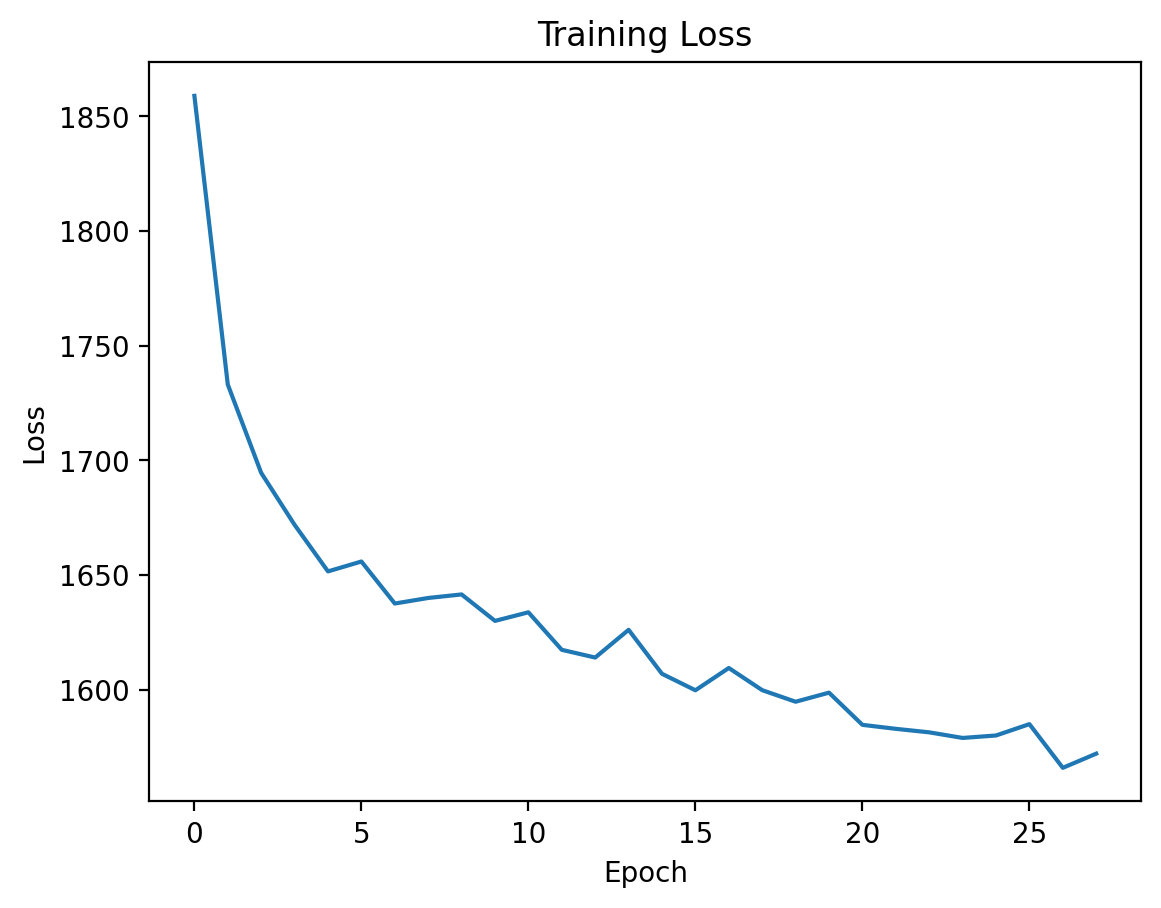

In [39]:
plt.plot(cNN_MLP.loss_curve_)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

#### 7. Pre-Trained ResNet with MLP Regressor Model (no normalizaiton, image resized)

Uncomment to run the code blocks below. Please note that this takes very long, worse performance

In [32]:
# resized_train_images = {'pixel_values': (transforms.Resize((224,224))(torch.from_numpy(train_images[:5000, [3, 2, 1], :, :]))).to(torch.float)}

# resized_validate_images = {'pixel_values': (transforms.Resize((224,224))(torch.from_numpy(validate_images[:1000, [3, 2, 1], :, :]))).to(torch.float)}

In [33]:
# with torch.no_grad():
#     outputs = pretrained_CNN(**resized_train_images) # Getting the outputs of the ResNet without the classifier

# resized_train_hidden = outputs.last_hidden_state

# with torch.no_grad():
#     outputs = pretrained_CNN(**resized_validate_images) # Getting the outputs of the ResNet without the classifier

# resized_validate_hidden = outputs.last_hidden_state

In [34]:
# flat_resized_train_hidden = resized_train_hidden.reshape(resized_train_hidden.shape[0], -1)
# flat_resized_validate_hidden = resized_validate_hidden.reshape(resized_validate_hidden.shape[0], -1)

In [47]:
# cNN_MLP2 = MLPRegressor(hidden_layer_sizes=(100,), max_iter= 100, learning_rate_init = .0001)
# cNN_MLP2.fit(flat_resized_train_hidden, train_values[:5000])
# print(f"R Squared: {cNN_MLP2.score(flat_resized_validate_hidden, validate_values[:1000])}")

R Squared: -3.757275889739626


In [48]:
# print(f"MSE: {mse(validate_values[:1000], cNN_MLP2.predict(flat_resized_validate_hidden[:1000]))}")

MSE: 13471.379389623817


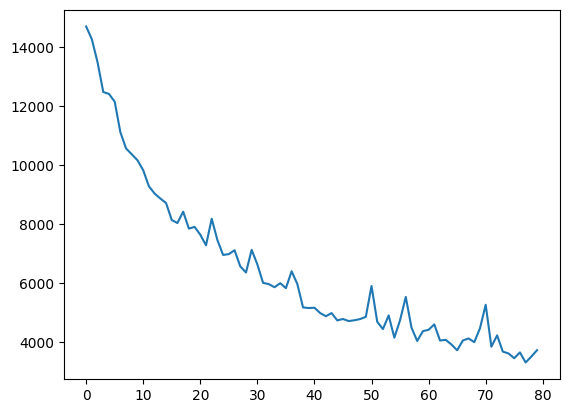

In [56]:
# plt.plot(cNN_MLP2.loss_curve_[20:])

#### 8. Custom Configured ResNet (no normalization, no image augmentation)

Uncomment to run (several models are commented out during hyperparameter tuning, only final model is uncommented)

In [9]:
allbands_train_dataset = Dataset.from_dict(
    {
        "pixel_values": torch.from_numpy(train_images).to(torch.float),
        "labels": train_values,
    }
)

allbands_eval_dataset = Dataset.from_dict(
    {
        "pixel_values": torch.from_numpy(validate_images).to(torch.float),
        "labels": validate_values,
    }
)

In [50]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 12, hidden_sizes = [256], depths = [16], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [15]:
# custom_model = ResNetForImageClassification.from_pretrained("test_trainer/checkpoint-3500")

In [18]:
# training_args = TrainingArguments(output_dir="test_trainer", per_device_train_batch_size=2000,
#                                   per_device_eval_batch_size=2000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=25.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=allbands_train_dataset,
#     eval_dataset=allbands_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [15]:
# trainer.train()

In [16]:
# trainer.train(resume_from_checkpoint = True)

Skipping the first batches: : 0it [00:03, ?it/s]


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=325, training_loss=1283.8534375, metrics={'train_runtime': 809.9801, 'train_samples_per_second': 772.735, 'train_steps_per_second': 0.401, 'total_flos': 1.18534225095e+16, 'train_loss': 1283.8534375, 'epoch': 25.0})

In [17]:
# data = pd.read_json('test_trainer/checkpoint-325/trainer_state.json')['log_history']

In [20]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [21]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [19]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 12, hidden_sizes = [256], depths = [32], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [20]:
# training_args = TrainingArguments(output_dir="test_trainer2", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=allbands_train_dataset,
#     eval_dataset=allbands_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train(resume_from_checkpoint = True)

In [22]:
# data = pd.read_json('test_trainer2/checkpoint-858/trainer_state.json')['log_history']

In [23]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [24]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

#### 8.5 pre-process all of the data (including cloud and location)

In [40]:
train_cloud = np.array(trainset["cloud"], dtype=np.float64)
train_cloud = train_cloud.transpose(0, 3, 1, 2)

validate_cloud = np.array(validateset["cloud"], dtype=np.float64)
validate_cloud = validate_cloud.transpose(0, 3, 1, 2)

test_cloud = np.array(testset["cloud"], dtype=np.float64)
test_cloud = test_cloud.transpose(0, 3, 1, 2)

train_lat = np.array(trainset["lat"], dtype=np.float64)
train_lat = train_lat.transpose(0, 3, 1, 2)

validate_lat = np.array(validateset["lat"], dtype=np.float64)
validate_lat = validate_lat.transpose(0, 3, 1, 2)

test_lat = np.array(testset["lat"], dtype=np.float64)
test_lat = test_lat.transpose(0, 3, 1, 2)

train_lon = np.array(trainset["lon"], dtype=np.float64)
train_lon = train_lon.transpose(0, 3, 1, 2)

validate_lon = np.array(validateset["lon"], dtype=np.float64)
validate_lon = validate_lon.transpose(0, 3, 1, 2)

test_lon = np.array(testset["lon"], dtype=np.float64)
test_lon = test_lon.transpose(0, 3, 1, 2)

In [41]:
alldata_train_dataset = Dataset.from_dict(
    {
        "pixel_values": torch.from_numpy(
            np.concatenate((train_images, train_cloud, train_lat, train_lon), axis=1)
        ).to(torch.float),
        "labels": train_values,
    }
)

alldata_eval_dataset = Dataset.from_dict(
    {
        "pixel_values": torch.from_numpy(
            np.concatenate(
                (validate_images, validate_cloud, validate_lat, validate_lon), axis=1
            )
        ).to(torch.float),
        "labels": validate_values,
    }
)

alldata_test_dataset = Dataset.from_dict(
    {
        "pixel_values": torch.from_numpy(
            np.concatenate((test_images, test_cloud, test_lat, test_lon), axis=1)
        ).to(torch.float),
        "labels": test_values,
    }
)

In [19]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256], depths = [50], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [22]:
# training_args = TrainingArguments(output_dir="allData_trainer", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [23]:
# trainer.train()

In [45]:
# data = pd.read_json('allData_trainer/checkpoint-858/trainer_state.json')['log_history']

In [46]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [47]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [20]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256], depths = [16], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [22]:
# training_args = TrainingArguments(output_dir="allData_trainer2", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=200.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [23]:
# trainer.train(resume_from_checkpoint = True)

Skipping the first batches: : 0it [00:02, ?it/s]


Epoch,Training Loss,Validation Loss


In [4]:
# data = pd.read_json('allData_trainer2/checkpoint-2080/trainer_state.json')['log_history']

In [5]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [6]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

/workspaces/Africa-Biomass-Challenge/.conda/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [27]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256], depths = [32], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [29]:
# training_args = TrainingArguments(output_dir="allData_trainer3", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train(resume_from_checkpoint = True)

In [31]:
# data = pd.read_json('allData_trainer3/checkpoint-728/trainer_state.json')['log_history']

In [32]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [33]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [78]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256, 25], depths = [32, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [79]:
# training_args = TrainingArguments(output_dir="allData_trainer4", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train()

In [81]:
# data = pd.read_json('allData_trainer4/checkpoint-260/trainer_state.json')['log_history']

In [82]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [83]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [13]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [256, 25], depths = [32, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [98]:
# training_args = TrainingArguments(output_dir="allData_trainer4-1", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=50.,
#                                   learning_rate=.01)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train()

In [103]:
# data = pd.read_json('allData_trainer4-1/checkpoint-312/trainer_state.json')['log_history']

In [104]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [105]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [ ]:
# Initializing a ResNet resnet-32 style configuration (with three added layers included, downsized for regularization)
configuration = ResNetConfig(
    num_channels=15, hidden_sizes=[256, 25], depths=[32, 3], num_labels=1
)

# Initializing a model (with random weights) from the resnet-50 style configuration
custom_model = ResNetForImageClassification(configuration)

# Accessing the model configuration
configuration = custom_model.config

In [14]:
training_args = TrainingArguments(
    output_dir="allData_trainer4-2",
    per_device_train_batch_size=1000,
    per_device_eval_batch_size=1000,
    logging_strategy="epoch",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=10.0,
    learning_rate=0.001,
)

mse_metric = evaluate.load("mse")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return mse_metric.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=custom_model,
    args=training_args,
    train_dataset=alldata_train_dataset,
    eval_dataset=alldata_eval_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

In [17]:
data = pd.read_json("allData_trainer4-2/checkpoint-1560/trainer_state.json")[
    "log_history"
]

In [18]:
df = pd.DataFrame()
for each in data:
    for keys in each:
        if keys != "epoch":
            df.loc[each["epoch"], keys] = each[keys]

In [19]:
alt.Chart(
    df.reset_index(names=["epoch"]).melt(
        id_vars=["epoch"],
        value_vars=["loss", "eval_loss"],
        var_name="train-eval",
        value_name="losses",
    )
).mark_line().encode(x="epoch", y="losses", color="train-eval")

alt.Chart(...)

In [84]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 225, 144, 100, 64, 25], depths = [3, 3, 3, 3, 3, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [85]:
# training_args = TrainingArguments(output_dir="allData_trainer5", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=50.)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train()

#### 9. Testing Trained ResNet-32 Model

In [18]:
resnet_32 = ResNetForImageClassification.from_pretrained(
    "allData_trainer4-2/checkpoint-78"
)  # Loading a pre-trained ResNet without the classifier

In [67]:
np.array(alldata_eval_dataset["pixel_values"]).shape

(5174, 15, 15, 15)

In [74]:
with torch.no_grad():
    # Getting the outputs of the ResNet without the classifier
    outputs = resnet_32(torch.tensor(alldata_test_dataset["pixel_values"]))

outputs.logits

tensor([[36.2939],
        [95.6092],
        [37.3444],
        ...,
        [40.4360],
        [33.0045],
        [50.9275]])

In [78]:
mse(
    np.array(alldata_test_dataset["labels"]),
    outputs.logits.numpy().reshape(-1),
    squared=False,
)

60.271914774627874

In [21]:
r2_score(np.array(alldata_test_dataset["labels"]), outputs.logits.numpy().reshape(-1))

-0.24529973661205218

# III. Experiments

### Step 1. Create Masks of Averages for Each Band

In [11]:
bandMeans = []
alldata_test_array = np.array(alldata_test_dataset["pixel_values"])
for eachBand in range(alldata_test_array.shape[1]):
    bandMeans.append(alldata_test_array[:, eachBand, :, :].mean())

### Step 2. Calculate RMSE and R-Squared for Masked Channels

In [24]:
for eachChannel in range(masked_array.shape[1]):
    masked_array = alldata_test_array.copy()

    masked_array[:, eachChannel, :, :] = bandMeans[eachChannel]

    with torch.no_grad():
        # Getting the outputs of the ResNet without the classifier
        outputs = resnet_32(torch.from_numpy(masked_array).to(torch.float32))

    print(
        f"Channel {eachChannel} MSE: {mse(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1), squared = False): .2f}"
    )

    print(
        f"Channel {eachChannel} R-Squared: {r2_score(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1)) * 100: .2f}%"
    )

Channel 0 MSE:  72.73
Channel 0 R-Squared: -24.53%
Channel 1 MSE:  71.92
Channel 1 R-Squared: -21.74%
Channel 2 MSE:  63.36
Channel 2 R-Squared:  5.49%
Channel 3 MSE:  60.53
Channel 3 R-Squared:  13.76%
Channel 4 MSE:  65.94
Channel 4 R-Squared: -2.35%
Channel 5 MSE:  82.54
Channel 5 R-Squared: -60.36%
Channel 6 MSE:  63.29
Channel 6 R-Squared:  5.72%
Channel 7 MSE:  61.83
Channel 7 R-Squared:  10.00%
Channel 8 MSE:  88.26
Channel 8 R-Squared: -83.37%
Channel 9 MSE:  60.30
Channel 9 R-Squared:  14.40%
Channel 10 MSE:  101.78
Channel 10 R-Squared: -143.84%
Channel 11 MSE:  66.18
Channel 11 R-Squared: -3.09%
Channel 12 MSE:  60.27
Channel 12 R-Squared:  14.49%
Channel 13 MSE:  60.30
Channel 13 R-Squared:  14.41%
Channel 14 MSE:  60.25
Channel 14 R-Squared:  14.56%


### Step 3: Conduct experiments according to paper

**RGB Only**

In [58]:
masked_array = alldata_test_array.copy()

for eachChannel in range(masked_array.shape[1]):
    if eachChannel not in [1, 2, 3, 12, 13, 14]:
        masked_array[:, eachChannel, :, :] = bandMeans[eachChannel]

with torch.no_grad():
    # Getting the outputs of the ResNet without the classifier
    outputs = resnet_32(torch.from_numpy(masked_array).to(torch.float32))

print(
    f"RGB only MSE: {mse(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1), squared = False): .2f}"
)

print(
    f"RGB only R-Squared: {r2_score(np.array(alldata_test_dataset['labels']), outputs.logits.numpy().reshape(-1)) * 100: .2f}%"
)

RGB only MSE:  69.13
RGB only R-Squared: -12.48%


In [ ]:
# data = pd.read_json('allData_trainer5/checkpoint-130/trainer_state.json')['log_history']

In [ ]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [ ]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

In [20]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 225, 144, 100, 64, 25], depths = [3, 3, 3, 3, 3, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [21]:
# training_args = TrainingArguments(output_dir="allData_trainer6", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=100.,
#                                   learning_rate=.001)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [23]:
# trainer.train(resume_from_checkpoint = True)

In [24]:
# data = pd.read_json('allData_trainer6/checkpoint-1612/trainer_state.json')['log_history']

In [25]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [26]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [42]:
alt.data_transformers.enable("default", max_rows=None)

DataTransformerRegistry.enable('default')

Visualizing Prediction Accuracy

In [49]:
model_data = ResNetForImageClassification(configuration)
model_data = model_data.from_pretrained("allData_trainer6/checkpoint-1300")
with torch.no_grad():
    predictions = model_data(torch.tensor(alldata_eval_dataset["pixel_values"]))
alt.Chart(
    pd.DataFrame(
        {
            "predictions": predictions["logits"].reshape(-1),
            "actual": torch.tensor(alldata_eval_dataset["labels"]),
        }
    )
).mark_point().encode(
    x=alt.X("predictions", scale=alt.Scale(domain=[0, 500])),
    y=alt.Y("actual", scale=alt.Scale(domain=[0, 500])),
)

alt.Chart(...)

In [ ]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 225, 144, 100, 64, 25], depths = [3, 3, 3, 3, 3, 3], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [108]:
# training_args = TrainingArguments(output_dir="allData_trainer6-2", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=50.,
#                                   learning_rate=.01)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train()

In [110]:
# data = pd.read_json('allData_trainer6-2/checkpoint-78/trainer_state.json')['log_history']

In [111]:
# df = pd.DataFrame()
# for each in data:
#     for keys in each:
#         if keys != 'epoch':
#             df.loc[each['epoch'], keys] = each[keys]

In [112]:
# alt.Chart(df.reset_index(names = ['epoch']).melt(id_vars = ['epoch'], value_vars = ['loss', 'eval_loss'], var_name='train-eval', value_name='losses')).mark_line().encode(x = 'epoch', y = 'losses', color = 'train-eval')

alt.Chart(...)

In [55]:
# # Initializing a ResNet resnet-50 style configuration
# configuration = ResNetConfig(num_channels = 15, hidden_sizes = [289, 144, 64, 25, 16], depths = [7, 7, 7, 7, 7], num_labels = 1)

# # Initializing a model (with random weights) from the resnet-50 style configuration
# custom_model = ResNetForImageClassification(configuration)

# # Accessing the model configuration
# configuration = custom_model.config

In [56]:
# training_args = TrainingArguments(output_dir="allData_trainer6-3", per_device_train_batch_size=1000,
#                                   per_device_eval_batch_size=1000, logging_strategy='epoch',
#                                   save_strategy = 'epoch',
#                                   evaluation_strategy = 'epoch',
#                                   num_train_epochs=10.,
#                                   learning_rate=.01)

# mse_metric = evaluate.load("mse")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     return mse_metric.compute(predictions=predictions, references=labels)


# trainer = Trainer(
#     model=custom_model,
#     args=training_args,
#     train_dataset=alldata_train_dataset,
#     eval_dataset=alldata_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train()